In [1]:
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Loading Images #

I chose a random golden gate bridge image, 'content.jpg'. I used that impressionist's painting, 'style.jpg'.

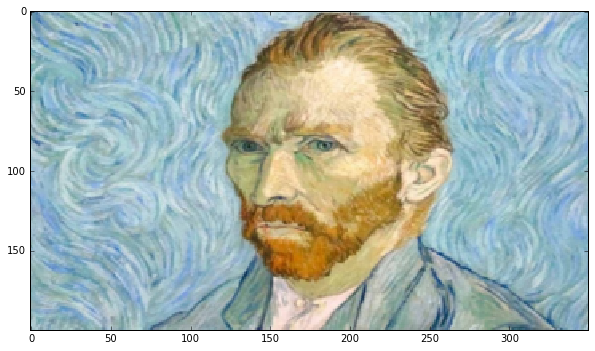

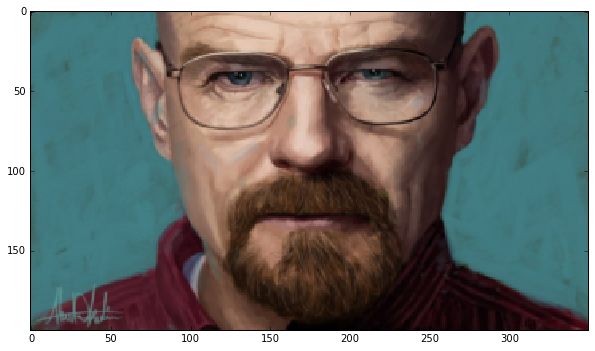

In [2]:
DIMS = [200,350]
style_image = scipy.misc.imresize(scipy.misc.imread('style.jpg'), DIMS)
plt.figure()
imshow(style_image)
content_image = scipy.misc.imresize(scipy.misc.imread('content.jpg'), DIMS)
plt.figure()
imshow(content_image)

(1, 1, 1, 3)
(200, 350, 3)


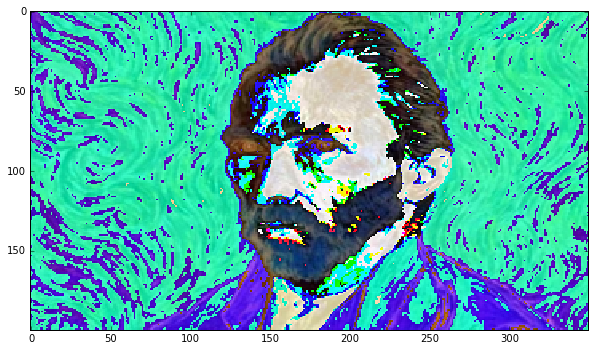

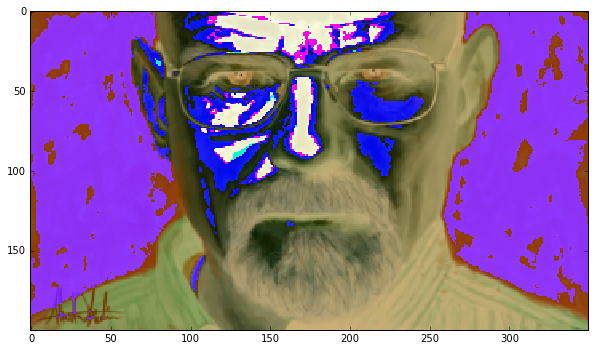

In [3]:
VGG_MEAN = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
data_dict = np.load('vgg19.npy', encoding='latin1').item()
print (VGG_MEAN.shape)
print (style_image.shape)
style_image = style_image - VGG_MEAN
plt.figure()
imshow(style_image[0])
content_image = content_image - VGG_MEAN
plt.figure()
imshow(content_image[0])

In [4]:
sorted(data_dict.keys())
# We can see that [0] is the weights, and [1] is the biases.

['conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv3_4',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv4_4',
 'conv5_1',
 'conv5_2',
 'conv5_3',
 'conv5_4',
 'fc6',
 'fc7',
 'fc8']

In [5]:
def _weights(data_dict, layer):
    """ Returns the weights in TF constant form """
    return tf.constant(data_dict[layer][0]), tf.constant(data_dict[layer][1])
def _conv(data_dict, prev_layer, layer):
    W,b = _weights(data_dict, layer)
    """ Returns a convolution filter activation with standard strides """
    return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b
def _conv_relu(data_dict, prev_layer, layer):
    """ Does both relu and conv """
    return tf.nn.relu(_conv(data_dict, prev_layer, layer))
def _pool(layer):
    """ pools with standard strides. avg_pool does better for style transfer according to Gatys et al. """
    return tf.nn.avg_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [6]:
input_shape = [1, *DIMS, 3]
x = tf.Variable(np.zeros(input_shape, dtype=np.float32))

In [7]:
conv1_1 = _conv_relu(data_dict, x, 'conv1_1')
conv1_2 = _conv_relu(data_dict, conv1_1, 'conv1_2')
pool1 = _pool(conv1_2)

conv2_1 = _conv_relu(data_dict, pool1, 'conv2_1')
conv2_2 = _conv_relu(data_dict, conv2_1, 'conv2_2')
pool2 = _pool(conv2_2)

conv3_1 = _conv_relu(data_dict, pool2, 'conv3_1')
conv3_2 = _conv_relu(data_dict, conv3_1, 'conv3_2')
conv3_3 = _conv_relu(data_dict, conv3_2, 'conv3_3')
conv3_4 = _conv_relu(data_dict, conv3_3, 'conv3_4')
pool3 = _pool(conv3_4)

conv4_1 = _conv_relu(data_dict, pool3, 'conv4_1')
conv4_2 = _conv_relu(data_dict, conv4_1, 'conv4_2')
conv4_3 = _conv_relu(data_dict, conv4_2, 'conv4_3')
conv4_4 = _conv_relu(data_dict, conv4_3, 'conv4_4')
pool4 = _pool(conv4_4)

conv5_1 = _conv_relu(data_dict, pool4, 'conv5_1')
conv5_2 = _conv_relu(data_dict, conv5_1, 'conv5_2')
conv5_3 = _conv_relu(data_dict, conv5_2, 'conv5_3')
conv5_4 = _conv_relu(data_dict, conv5_3, 'conv5_4')


# From Gatys et al. :
# "The images were synthesized by matching content representation on layer 'conv4_2',... 
# style on layers 'conv1_1','conv2_1','conv3_1','conv4_1','conv5_1'."
# Let's use what they prescribed.


# Style Transfer #

The style transfer paper: 

$L_{total}(p,a,x) = \alpha L_{content}(p,x) + \beta L_{style}(a,x) = \alpha (\frac{1}{2}\sum_{i,j}(P_{ij}^l-F_{ij}^l)^2)) + \beta (\sum_lw_lE_l)$

In [8]:
CONTENT_LAYER = conv4_2
STYLE_LAYERS = (conv1_1, conv2_1, conv3_1, conv4_1, conv5_1) 
STYLE_WEIGHTS = (0.5,1.,1.5,3.,4.)
alpha = 100
beta = 5
ITERS = 3000

In [9]:
def initialize(content_image):
    return np.reshape((np.random.rand(*input_shape)*150-75) * 0.5 + (content_image[0]) * 0.5, content_image.shape)

In [10]:
def L_content(p):
    N = p.shape[3]
    M = p.shape[1]*p.shape[2]
    L = tf.reduce_sum(tf.pow((p-CONTENT_LAYER),2)) / (2 * N * M)
    return L

def L_style_layer(a, x):
    N = a.shape[3]
    M = a.shape[1]*a.shape[2]
    _x = tf.reshape(x, [M, N])
    _a = tf.reshape(a, [M, N])
    G = tf.matmul(tf.transpose(_x), _x)
    A = tf.matmul(tf.transpose(_a), _a)
    L = tf.reduce_sum(tf.pow((G-A), 2)) / (4 * N**2 * M**2)
    return L

def L_style(a, w):
    L = 0
    for i, style in enumerate(STYLE_LAYERS):
        L += w[i]*L_style_layer(a[i], style)
    return L

def L(a, p, w):
    return alpha * L_content(p) + beta * L_style(a, w)

15 213


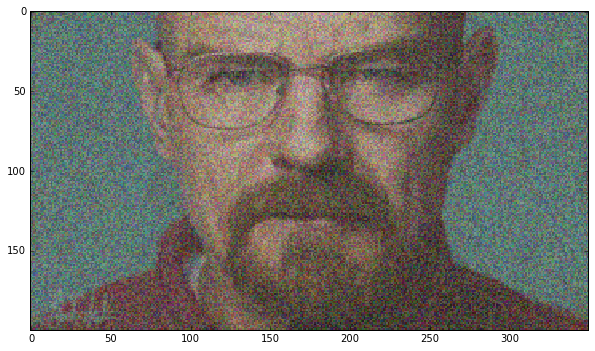

In [11]:
# A quick look at initialize()
im = np.array(np.minimum(np.maximum((initialize(content_image) + VGG_MEAN)[0], 0), 255), dtype=np.uint8)
imshow(im)
print(np.min(im), np.max(im))

In [ ]:
init_op = tf.global_variables_initializer()

# Launch the graph in a session.
with tf.Session() as sess:
    # Run the Op that initializes global variables.
    sess.run(x.assign(content_image))
    content = sess.run(conv4_2)
    sess.run(x.assign(style_image))
    style = [sess.run(style) for style in STYLE_LAYERS]
    for s in style:
        print(s.shape)
    loss = L(style, content, STYLE_WEIGHTS)
    train_op = tf.train.AdamOptimizer(2.).minimize(loss)
    sess.run(tf.global_variables_initializer())
    sess.run(x.assign(initialize(content_image)))
    for i in range(ITERS):
        sess.run(train_op)
        if i % 10 == 0:
            print('cost at the ', i,' -th iter: ', sess.run(loss))
        if i % 100 == 0:
            image = np.array(np.minimum(np.maximum((sess.run(x) + VGG_MEAN)[0], 0), 255), dtype=np.uint8)
            scipy.misc.imsave('out.jpg', image)

(1, 200, 350, 64)
(1, 100, 175, 128)
(1, 50, 88, 256)
(1, 25, 44, 512)
(1, 13, 22, 512)
cost at the 